In [2]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
from pandas.api.types import CategoricalDtype
import pickle

import sklearn
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

os.chdir("/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data")
print(os.getcwd())

/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data


In [3]:
import gc
gc.collect()

31

In [4]:
# Read in Treatment Episode Data Set data
teds18 = pd.read_csv('tedsa_puf_2018.csv')

In [5]:
teds18.columns

Index(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
       'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
       'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
       'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
       'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
       'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'REGION', 'IDU', 'ALCDRUG'],
      dtype='object')

In [6]:
# Subset the data to just the 0/1 drug flag variables
flags = teds18.filter(regex='FLG$', axis = 1)

In [7]:
# Sum the flag variables to calculate the number of drugs recorded for each individual
NUMSUBS = flags.sum(axis=1)

In [8]:
# Concatenate flag variables back into the 2015-17 data
teds_wflgs = pd.concat([teds18, NUMSUBS], axis = 1)
teds_wflgs.rename(columns={0:'NUMSUBS'}, inplace = True)

In [9]:
# Remove rows where the first substance was "None"
teds_sm_temp = teds_wflgs[teds_wflgs.SUB1 != 1]
# Remove rows where number of prior treatments is NA (target variable)
teds_sm1 = teds_sm_temp[teds_sm_temp.NOPRIOR != -9]

In [10]:
# Select subset of columns
teds_sm = teds_sm1.loc[:,['CASEID','ADMYR','AGE','GENDER','RACE','ETHNIC','EDUC','EMPLOY','VET','LIVARAG',\
                          'STFIPS','CBSA2010','DIVISION','REGION','SERVICES','PSOURCE','NOPRIOR','ARRESTS','ROUTE1','FRSTUSE1','FREQ1', \
                          'ROUTE2','FRSTUSE2', 'FREQ2','ROUTE3','FRSTUSE3','FREQ3','NUMSUBS','METHUSE','ALCFLG','PSYPROB', \
                          'COKEFLG','MARFLG','HERFLG','METHFLG','OPSYNFLG','PCPFLG','HALLFLG','MTHAMFLG','AMPHFLG','STIMFLG', \
                          'BENZFLG','TRNQFLG','BARBFLG','SEDHPFLG','INHFLG','OTCFLG','OTHERFLG']]

In [11]:
# Recode age group variable
def age_groups(series):
    if series == 1:
        return '12_14_years'
    elif series == 2:
        return '15_17_years'
    elif series == 3:
        return '18_20_years'
    elif series == 4:
        return '21_24_years'
    elif series == 5:
        return '25_29_years'
    elif series == 6:
        return '30_34_years'
    elif series == 7:
        return '35_39_years'
    elif series == 8:
        return '40_44_years'
    elif series == 9:
        return '45_49_years'
    elif series == 10:
        return '50_54_years'
    elif series == 11:
        return '55_64_years'
    elif series == 12:
        return '65_plus_years'
    
teds_sm1.loc[:, 'age_group'] = teds_sm1.AGE.apply(age_groups)

# Change variable to an ordered factor
teds_sm1.loc[:, 'age_group'] = pd.Categorical(teds_sm1['age_group'], categories = ['12_14_years', '15_17_years', '18_20_years',
                                                                                   '21_24_years', '25_29_years', '30_34_years',
                                                                                   '35_39_years', '40_44_years', '45_49_years',
                                                                                   '50_54_years', '55_64_years', '65_plus_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'age_group'], sort = True)
teds_sm1.loc[:, 'age_group'] = labels

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
# Recode gender variable
def gen_rc(series):
    if series == 1:
        return 0
    elif series == 2:
        return 1
    
teds_sm1.loc[:, 'gender'] = teds_sm1.GENDER.apply(gen_rc)

In [13]:
# Recode methadone variable
def methadone_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'methadone_use'] = teds_sm1.METHUSE.apply(methadone_rc)

In [14]:
def educ_rc(series):
    if series == 1:
        return 'No_Schooling'
    elif series == 2:
        return 'Grades_9_to_11'
    elif series == 3:
        return 'Grades_12_or_GED'
    elif series == 4:
        return 'College_1_to_3_years'
    elif series == 5:
        return 'College_4_or_more_years'

teds_sm1.loc[:, 'educ'] = teds_sm1.EDUC.apply(educ_rc)

# Change variable to an ordered factor
teds_sm1.loc[:, 'educ'] = pd.Categorical(teds_sm1['educ'], categories = ['No_Schooling', 'Grades_9_to_11', 'Grades_12_or_GED',
                                                                         'College_1_to_3_years', 'College_4_or_more_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'educ'], sort = True)
teds_sm1.loc[:, 'educ'] = labels

In [15]:
# Record race variable
def race_rc(series):
    if series == 1:
        return 'Alaska_Native'
    elif series == 2:
        return 'American_Indian'
    elif series == 3 or series == 9:
        return 'Hawaiian_Pacific_Islander'
    elif series == 4:
        return 'Black'
    elif series == 5:
        return 'White'
    elif series == 6:
        return 'Asian'
    elif series == 7:
        return 'Other_race'
    elif series == 8:
        return 'Two_or_more_races'
    
teds_sm1.loc[:, 'race'] = teds_sm1.RACE.apply(race_rc)

In [16]:
# Recode ethnicity variable
def ethnic_rc(series):
    if (series >= 1 or series <= 3) or series == 5:
        return 1
    elif series == 4:
        return 0
    
teds_sm1.loc[:, 'ethnic'] = teds_sm1.ETHNIC.apply(ethnic_rc)

In [17]:
# Recode service setting variable
def servseta_rc(series):
    if series == 1 or series == 2:
        return 'Detox'
    elif series >= 3 and series <= 5:
        return 'Rehab_Residential'
    elif series >= 6 and series <= 8:
        return 'Ambulatory'

teds_sm1.loc[:, 'services'] = teds_sm1.SERVICES.apply(servseta_rc)

In [18]:
# Recode marital status variable
def marstat_rc(series):
    if series == 1:
        return 'Never_Married'
    elif series == 2:
        return 'Married'
    elif series == 3:
        return 'Separated'
    elif series == 4:
        return 'Divorced_or_Widowed'

teds_sm1.loc[:, 'marstat'] = teds_sm1.MARSTAT.apply(marstat_rc)

In [19]:
# Recode employment status variable
def employ_rc(series):
    if series == 1:
        return 'Full_time'
    elif series == 2:
        return 'Part_time'
    elif series == 3:
        return 'Unemployed'
    elif series == 4:
        return 'Not_in_labor_force'
    
teds_sm1.loc[:, 'employ'] = teds_sm1.EMPLOY.apply(employ_rc)

In [20]:
# Recode veteran variable
def vet_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'vet'] = teds_sm1.VET.apply(vet_rc)

In [21]:
# Recode living arrangement variable
def livarag_rc(series):
    if series == 1:
        return 'Homeless'
    elif series == 2:
        return 'Dependent_Living'
    elif series == 3:
        return 'Independent_Living'

teds_sm1.loc[:, 'livarag'] = teds_sm1.LIVARAG.apply(livarag_rc)

In [22]:
# Recode arrests variable
def arrests_rc(series):
    if series == 0:
        return 'None'
    elif series == 1:
        return 'Once'
    elif series == 2:
        return 'Two_or_more_times'
    
teds_sm1.loc[:, 'arrests'] = teds_sm1.ARRESTS.apply(arrests_rc)

# Change variable to an ordered factor variable
teds_sm1.loc[:, 'arrests'] = pd.Categorical(teds_sm1['arrests'], categories = ['None', 'Once',
                                                                              '2 or more times'],
                                           ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'arrests'], sort = True)
teds_sm1.loc[:, 'arrests'] = labels

In [23]:
# Recode division variable
def division_rc(series):
    if series == 0:
        return 'US_Territories'
    elif series == 1:
        return 'New_England'
    elif series == 2:
        return 'Mid_Atlantic'
    elif series == 3:
        return 'East_North_Central'
    elif series == 4:
        return 'West_North_Central'
    elif series == 5:
        return 'South_Atlantic'
    elif series == 6:
        return 'East_South_Central'
    elif series == 7:
        return 'West_South_Central'
    elif series == 8:
        return 'Mountain'
    elif series == 9:
        return 'Pacific'
    
teds_sm1.loc[:, 'division'] = teds_sm1.DIVISION.apply(division_rc)

In [24]:
# Recode referral source variable
def psource_rc(series):
    if series == 1:
        return 'Self_referral'
    elif series == 2:
        return 'Alcohol_Drug_Care_Professional'
    elif series == 3:
        return 'Other_Health_Care_Professional'
    elif series == 4:
        return 'School_Referral'
    elif series == 5:
        return 'Employer_Referral'
    elif series == 6:
        return 'Community_Referral'
    elif series == 7:
        return 'Court_Referral'
    
teds_sm1.loc[:, 'psource'] = teds_sm1.PSOURCE.apply(psource_rc)

In [25]:
# Recode number of prior treatment encounters
def noprior_rc(series):
    if series == 0:
        return 0
    elif series >= 1:
        return 1
    
teds_sm1.loc[:, 'noprior'] = teds_sm1.NOPRIOR.apply(noprior_rc)

In [26]:
# Recode mental illness variable
def psyprob_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'psyprob'] = teds_sm1.PSYPROB.apply(psyprob_rc)

In [27]:
# Recode number of substances variable
def numsubs_rc(series):
    if series == 0:
        return 'Zero_substances'
    elif series == 1:
        return 'One_substance'
    elif series == 2:
        return 'Two_substances'
    elif series == 3:
        return 'Three_substances'
    
teds_sm1.loc[:, 'numsubs'] = teds_sm1.NUMSUBS.apply(numsubs_rc)

# Change first use into an ordered factor
teds_sm1.loc[:, 'numsubs'] = pd.Categorical(teds_sm1['numsubs'], categories = ['Zero substances', 'One substance',
                                                                               'Two substances', "Three substances"], ordered = True)

# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'numsubs'], sort = True)
teds_sm1.loc[:, 'numsubs'] = labels

In [28]:
def first_age_recode(column1, column2, column3):
    if column1 == 1 or column2 == 1 or column3 == 1:
        return '11_years_and_under'
    elif column1 == 2 or column2 == 2 or column3 == 2:
        return '12_14_years'
    elif column1 == 3 or column2 == 3 or column3 == 3:
        return '15_17_years'
    elif column1 == 4 or column2 == 4 or column3 == 4:
        return '18_20_years'
    elif column1 == 5 or column2 == 5 or column3 == 5:
        return '21_24_years'
    elif column1 == 6 or column2 == 6 or column3 == 6:
        return '25_29_years'
    elif column1 == 7 or column2 == 7 or column3 == 7:
        return '30_years_older'

teds_sm1.loc[:, 'frstuse'] = teds_sm1.apply(lambda x: first_age_recode(x.FRSTUSE1, x.FRSTUSE2, x.FRSTUSE3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'frstuse'] = pd.Categorical(teds_sm1['frstuse'], categories = ['11_years_and_under', '12_14_years', '15_17_years',
                                                                               '18_20_years', '21_24_years',
                                                                               '25_29_years', '30_years_older'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'frstuse'], sort = True)
teds_sm1.loc[:, 'frstuse'] = labels

In [29]:
def freq_recode(column1, column2, column3):
    if (column1 == 1 and column2 == 1 and column3 == 1):
        return 'No_Use_Past_Month'
    elif (column1 == 3 or column2 == 3 or column3 == 3):
        return 'Daily_Use'
    elif (column1 == 2 or column2 == 2 or column3 == 2):
        return 'Some_Use'
    elif (column1 == 1 or column2 == 1 or column3 == 1):
        return 'No_Use_Past_Month'

teds_sm1.loc[:, 'freq_use'] = teds_sm1.apply(lambda x: freq_recode(x.FREQ1, x.FREQ2, x.FREQ3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'freq_use'] = pd.Categorical(teds_sm1['freq_use'], categories = ['No_Use_Past_Month', 'Daily_Use', 'Some_Use'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'freq_use'], sort = True)
teds_sm1.loc[:, 'freq_use'] = labels

In [30]:
def oral_recode(column1, column2, column3):
    if (column1 == 1 and column1 != None) or (column2 == 1 and column2 != None) or (column3 == 1 and column3 != None):
        return 1
    elif (column1 > 1 and column1 != None) or (column2 > 1 and column2 != None) or (column3 > 1 and column3 != None):
        return 0

teds_sm1.loc[:, 'oral_drug_use'] = teds_sm1.apply(lambda x: oral_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def smoking_recode(column1, column2, column3):
    if (column1 == 2 and column1 != None) or (column2 == 2 and column2 != None) or (column3 == 2 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0

teds_sm1.loc[:, 'smoking_drug_use'] = teds_sm1.apply(lambda x: smoking_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def inhalation_recode(column1, column2, column3):
    if (column1 == 3 and column1 != None) or (column2 == 3 and column2 != None) or (column3 == 3 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'inhale_drug_use'] = teds_sm1.apply(lambda x: inhalation_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)
    
def injection_recode(column1, column2, column3):
    if (column1 == 4 and column1 != None) or (column2 == 4 and column2 != None) or (column3 == 4 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'injection_drug_use'] = teds_sm1.apply(lambda x: injection_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

In [31]:
# Subset to fewer variables, mostly dropping those with many missing values
teds_clean = teds_sm1.drop(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
                            'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
                            'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
                            'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
                            'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
                            'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP', 
                            'IDU','REGION'], axis = 1)

In [32]:
teds_clean.columns

Index(['ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'ALCDRUG', 'NUMSUBS', 'age_group', 'gender',
       'methadone_use', 'educ', 'race', 'ethnic', 'services', 'marstat',
       'employ', 'vet', 'livarag', 'arrests', 'division', 'psource', 'noprior',
       'psyprob', 'numsubs', 'frstuse', 'freq_use', 'oral_drug_use',
       'smoking_drug_use', 'inhale_drug_use', 'injection_drug_use'],
      dtype='object')

In [33]:
# Create dummy variables for unordered categorical variables
teds2018 = pd.get_dummies(teds_clean, columns=['race','psource','division','ethnic','services','marstat','employ',
                                                 'livarag'])

In [34]:
# Subset data for easy analysis
teds2018 = teds2018.sample(n = 200000, random_state=16)

In [4]:
#teds2018.to_csv("teds_data_small.csv",index=False)
teds2018 = pd.read_csv("teds_data_small.csv")

In [5]:
# Drop response variable and year since only 2017 will be used in final modeling
data = teds2018.drop(columns = ['noprior'])
# Create data frame with just the response variable
response = teds2018.loc[:,['noprior']]

In [6]:
# Impute missing data witn mode
my_imputer = SimpleImputer(strategy = 'most_frequent')
data_imputed = pd.DataFrame(my_imputer.fit_transform(data))
data_imputed.columns = data.columns
columns = data_imputed.columns

In [7]:
# Change response and predictor data frames to numpy arrays
data_imp_np = np.array(data_imputed)
response_np = np.array(response)

In [8]:
# Create holdout data set and keep remaining 80% in one data frame
# Used stratefied random sampling because there was class imbalance
sss = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)

sss.get_n_splits(data_imp_np, response_np)

for train_index, test_index in sss.split(data_imp_np, response_np):
    x_train_temp, x_test = data_imp_np[train_index], data_imp_np[test_index]
    y_train_temp, y_test = response_np[train_index], response_np[test_index]

# Split the remaining data into a training and validation data set (50% and 30% respectively)
sss_valid = StratifiedShuffleSplit(n_splits = 2, test_size = 0.3, random_state = 10)  
    
for train_index, test_index in sss_valid.split(x_train_temp, y_train_temp):
    x_train, x_validation = x_train_temp[train_index], x_train_temp[test_index]
    y_train, y_validation = y_train_temp[train_index], y_train_temp[test_index]

    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [9]:
# Create user-defined function to create formatted confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=20, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)


# Logistic Regression Model

This is the logistic regression model you have likely heard of before. Its C parameter is 1 so no regularization is performed to decrease the values/penalize coefficients.

In [11]:
# Run logistic regression model as a baseline
logreg_model = LogisticRegression()
logreg_model.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_logreg = logreg_model.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.52      0.59     19253
           1       0.72      0.83      0.77     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.67      0.68     48000
weighted avg       0.70      0.71      0.70     48000


Normalized confusion matrix



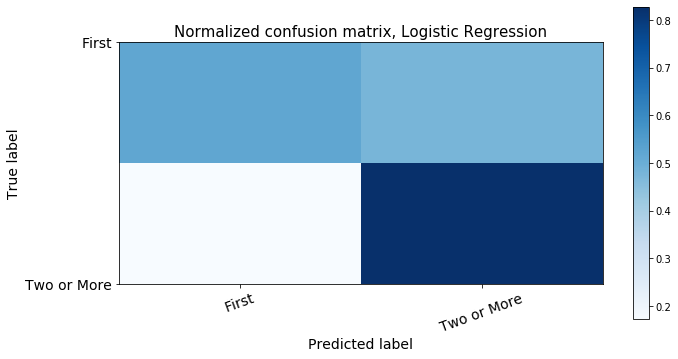

In [12]:
# Print classification report
print(classification_report(y_validation, valid_predict_logreg))

# Assign classes
class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_logreg = confusion_matrix(y_validation, valid_predict_logreg)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_logreg, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Logistic Regression')

# Results: Accuracy is 71%, but very bad accuracy for identifying first admission patients

In [13]:
# Create a data frame with coefficients
logreg_coefs = pd.DataFrame(columns, list(logreg_model.coef_)).reset_index()
logreg_coefs.columns = ['coefficients','features']
logreg_coefs = logreg_coefs.sort_values(by='coefficients', ascending=False)
logreg_coefs

,coefficients,features
35,1.344424,race_Alaska_Native
53,0.964959,division_Mountain
58,0.681342,division_West_North_Central
6,0.582636,PCPFLG
43,0.534430,psource_Alcohol_Drug_Care_Professional
...,...,...
70,-0.482592,employ_Part_time
68,-0.592550,employ_Full_time
10,-0.688233,STIMFLG
55,-0.942245,division_Pacific


In [14]:
# Finding the mean coefficient
logreg_coefs.coefficients.mean()

0.04510915238682355

<Figure size 1440x576 with 0 Axes>

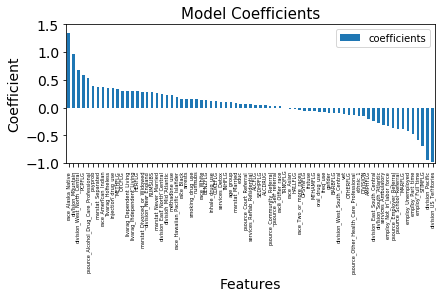

<Figure size 1440x576 with 0 Axes>

In [15]:
# Plotting logistic regression coefficients
logreg_coefs.plot(kind='bar')
plt.title('Model Coefficients', fontsize = 15)
classes = logreg_coefs.loc[:,'features']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize = 5)
plt.yticks(fontsize = 14)

plt.tight_layout()
plt.ylabel("Coefficient",fontsize = 14)
plt.xlabel("Features",fontsize = 14)

plt.ylim([-1, 1.5])
plt.figure(figsize=(20,8))

# Ridge Regression Model

Below is an example of Ridge Regression. Regularization is being applied to penalize the coefficients to drive them towards zero. Ridge Regression is specified by "penalty=0.2" in the example below. This will decrease overfitting. With Ridge Regression coefficients can go close to zero but are never exactly zero.

The lower C is, the higher the penalty and lower the coefficients are in your model.

## C = 0.2
Below the C parameter in the Ridge Regression model is 0.2.

In [16]:
c_value = 0.2

# Run ridge regression model with a c (regularization parameter) of 0.2
ridge_model2 = LogisticRegression(penalty = 'l2', C = c_value)
ridge_model2.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_ridge2 = ridge_model2.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.52      0.59     19253
           1       0.72      0.83      0.77     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.67      0.68     48000
weighted avg       0.70      0.71      0.70     48000


Normalized confusion matrix



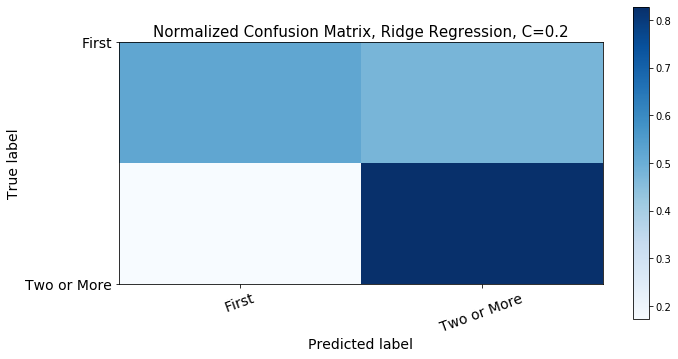

In [17]:
# Print classification report
print(classification_report(y_validation, valid_predict_ridge2))

# Assign classes
class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_ridge2 = confusion_matrix(y_validation, valid_predict_ridge2)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_ridge2, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix, Ridge Regression, C=0.2')

# Results: Accuracy is 71%, but very bad accuracy for identifying first admission patients

In [18]:
# Create a data frame with coefficients
ridge2_coefs = pd.DataFrame(columns, list(ridge_model2.coef_)).reset_index()
ridge2_coefs.columns = ['coefficients','features']
ridge2_coefs = ridge2_coefs.sort_values(by='coefficients', ascending=False)
ridge2_coefs

,coefficients,features
35,1.230329,race_Alaska_Native
53,0.966074,division_Mountain
58,0.670283,division_West_North_Central
6,0.563900,PCPFLG
43,0.532893,psource_Alcohol_Drug_Care_Professional
...,...,...
70,-0.475537,employ_Part_time
68,-0.586483,employ_Full_time
10,-0.668094,STIMFLG
57,-0.924999,division_US_Territories


In [19]:
# Mean of all coefficients
ridge2_coefs.coefficients.mean()

0.0431375645611084

<Figure size 1440x576 with 0 Axes>

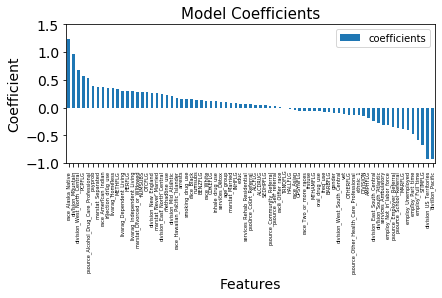

<Figure size 1440x576 with 0 Axes>

In [20]:
# Plotting coefficients
ridge2_coefs.plot(kind='bar')
plt.title('Model Coefficients', fontsize = 15)
classes = ridge2_coefs.loc[:,'features']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize = 5)
plt.yticks(fontsize = 14)

plt.tight_layout()
plt.ylabel("Coefficient",fontsize = 14)
plt.xlabel("Features",fontsize = 14)

plt.ylim([-1, 1.5])
plt.figure(figsize=(20,8))

## C = 0.001
Below the C parameter in the Ridge Regression model is 0.001.

In [21]:
# Run ridge regression model with a c (regularization parameter) of 0.001
c_value = 0.001

ridge_model001 = LogisticRegression(penalty = 'l2', C = c_value)
ridge_model001.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_ridge001 = ridge_model001.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.51      0.58     19253
           1       0.72      0.83      0.77     28747

    accuracy                           0.70     48000
   macro avg       0.69      0.67      0.68     48000
weighted avg       0.70      0.70      0.69     48000


Normalized confusion matrix



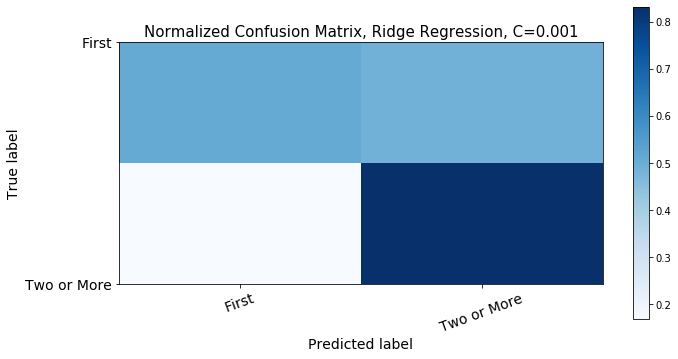

In [22]:
# Print classification report
print(classification_report(y_validation, valid_predict_ridge001))

# Assign classes
class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_ridge001 = confusion_matrix(y_validation, valid_predict_ridge001)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_ridge001, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix, Ridge Regression, C=0.001')

# Results: Accuracy is 70%, but very bad accuracy for identifying first admission patients

In [41]:
# Create a data frame with coefficients
ridge001_coefs = pd.DataFrame(columns, list(ridge_model001.coef_)).reset_index()
ridge001_coefs.columns = ['coefficients','features']
ridge001_coefs = ridge001_coefs.sort_values(by='coefficients', ascending=False)
ridge001_coefs.iloc[0:30,:]

,coefficients,features
53,0.694294,division_Mountain
58,0.336906,division_West_North_Central
27,0.329715,psyprob
3,0.312641,HERFLG
43,0.277009,psource_Alcohol_Drug_Care_Professional
34,0.256243,injection_drug_use
20,0.249511,NUMSUBS
66,0.213173,marstat_Never_Married
64,0.169129,marstat_Divorced_or_Widowed
23,0.167271,methadone_use


In [24]:
# Mean coefficient value
ridge001_coefs.coefficients.mean()

0.02114564965263451

<Figure size 1440x576 with 0 Axes>

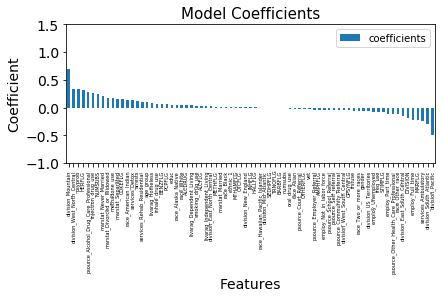

<Figure size 1440x576 with 0 Axes>

In [25]:
# Plotting coefficients
ridge001_coefs.plot(kind='bar')
plt.title('Model Coefficients', fontsize = 15)
classes = ridge001_coefs.loc[:,'features']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize = 5)
plt.yticks(fontsize = 14)

plt.tight_layout()
plt.ylabel("Coefficient",fontsize = 14)
plt.xlabel("Features",fontsize = 14)
plt.ylim([-1, 1.5])

plt.figure(figsize=(20,8))

# Lasso Regression
Below are examples of Lasso Regression. Lasso Regression is specified by the "penalty='l1'" in the model below. Regularization is being applied to penalize the coefficients to drive them to zero. This will decrease overfitting. Lasso Regression differs from Ridge Regression because it will drive features with low coefficients all the way to zero, removing them from the model all together. More information will be lost for less important features in Lasso versus Ridge Regression.

The lower C is, the higher the penalty and lower the coefficients are in your model.

# C = 0.2
Below is a Lasso Regression model with a C value of 0.2

In [26]:
c_value = 0.2

# Run lasso regression model with a c (regularization parameter) of 0.2
lasso_model2 = LogisticRegression(penalty = 'l1', C = c_value)
lasso_model2.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_lasso2 = lasso_model2.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.52      0.59     19253
           1       0.72      0.83      0.77     28747

    accuracy                           0.71     48000
   macro avg       0.70      0.67      0.68     48000
weighted avg       0.70      0.71      0.70     48000


Normalized confusion matrix



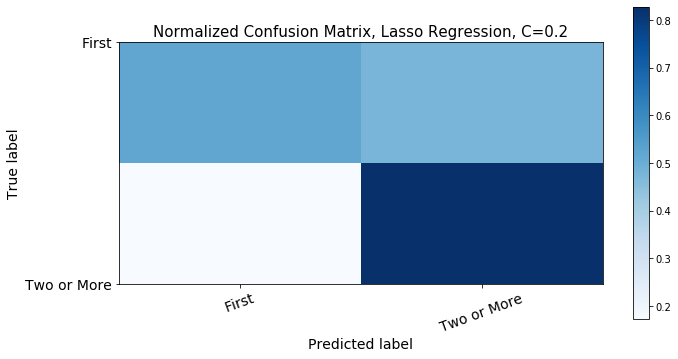

In [27]:
# Print classification report
print(classification_report(y_validation, valid_predict_lasso2))

# Assign classes
class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_lasso2 = confusion_matrix(y_validation, valid_predict_lasso2)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_lasso2, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix, Lasso Regression, C=0.2')

# Results: Accuracy is 71%, but very bad accuracy for identifying first admission patients

In [42]:
# Create a data frame with coefficients
lasso2_coefs = pd.DataFrame(columns, list(lasso_model2.coef_)).reset_index()
lasso2_coefs.columns = ['coefficients','features']
lasso2_coefs = lasso2_coefs.sort_values(by='coefficients', ascending=False)
lasso2_coefs

,coefficients,features
35,1.250688,race_Alaska_Native
53,1.126461,division_Mountain
58,0.585833,division_West_North_Central
6,0.540720,PCPFLG
43,0.522833,psource_Alcohol_Drug_Care_Professional
...,...,...
70,-0.461117,employ_Part_time
68,-0.572903,employ_Full_time
10,-0.655817,STIMFLG
55,-0.705503,division_Pacific


In [29]:
# Mean of all coefficients
lasso2_coefs.coefficients.mean()

0.0299886425724353

<Figure size 1440x576 with 0 Axes>

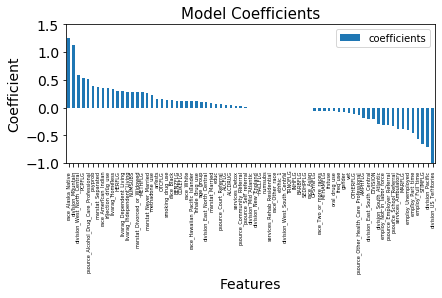

<Figure size 1440x576 with 0 Axes>

In [30]:
# Plotting coefficients
lasso2_coefs.plot(kind='bar')
plt.title('Model Coefficients', fontsize = 15)
classes = lasso2_coefs.loc[:,'features']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize = 5)
plt.yticks(fontsize = 14)

plt.tight_layout()
plt.ylabel("Coefficient",fontsize = 14)
plt.xlabel("Features",fontsize = 14)

plt.ylim([-1, 1.5])
plt.figure(figsize=(20,8))

## C = 0.001
Below the C parameter in the Lasso Regression model is 0.001.

In [31]:
c_value = 0.001

# Run lasso regression model with a c (regularization parameter) of 0.001
lasso_model001 = LogisticRegression(penalty = 'l1', C = c_value)
lasso_model001.fit(x_train, np.ravel(y_train, order='C'))
valid_predict_lasso001 = lasso_model001.predict(x_validation)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.66      0.48      0.55     19253
           1       0.70      0.83      0.76     28747

    accuracy                           0.69     48000
   macro avg       0.68      0.66      0.66     48000
weighted avg       0.69      0.69      0.68     48000


Normalized confusion matrix



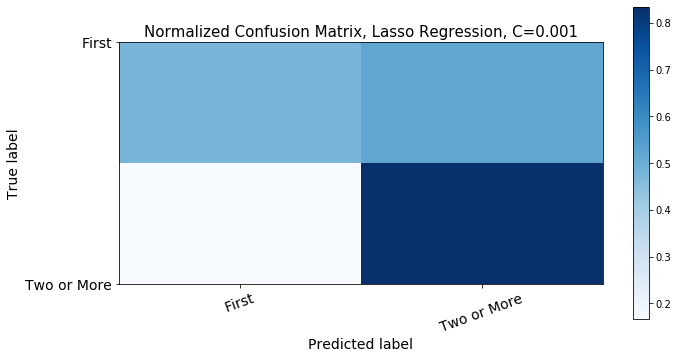

In [32]:
# Print classification report
print(classification_report(y_validation, valid_predict_lasso001))

# Assign classes
class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_lasso001 = confusion_matrix(y_validation, valid_predict_lasso001)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_lasso001, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix, Lasso Regression, C=0.001')

# Results: Accuracy is 69%, but very bad accuracy for identifying first admission patients

In [40]:
# Create a data frame with coefficients
lasso001_coefs = pd.DataFrame(columns, list(lasso_model001.coef_)).reset_index()
lasso001_coefs.columns = ['coefficients','features']
lasso001_coefs = lasso001_coefs.sort_values(by='coefficients', ascending=False)
lasso001_coefs.iloc[0:30,:]

,coefficients,features
53,0.787206,division_Mountain
20,0.306137,NUMSUBS
3,0.294526,HERFLG
27,0.254061,psyprob
34,0.152426,injection_drug_use
21,0.123201,age_group
66,0.109107,marstat_Never_Married
58,0.094121,division_West_North_Central
24,0.029675,educ
50,0.000000,division_East_North_Central


In [34]:
# Mean of all coefficients
lasso001_coefs.coefficients.mean()

0.022030858595114854

<Figure size 1440x576 with 0 Axes>

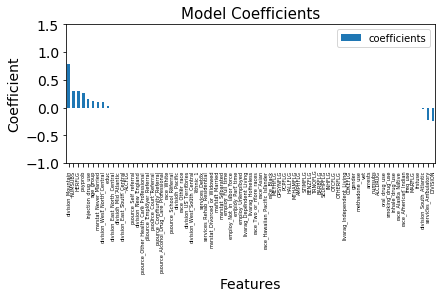

<Figure size 1440x576 with 0 Axes>

In [35]:
# Plotting coefficients
lasso001_coefs.plot(kind='bar')
plt.title('Model Coefficients', fontsize = 15)
classes = lasso001_coefs.loc[:,'features']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize = 5)
plt.yticks(fontsize = 14)

plt.tight_layout()
plt.ylabel("Coefficient",fontsize = 14)
plt.xlabel("Features",fontsize = 14)

plt.ylim([-1, 1.5])
plt.figure(figsize=(20,8))

<Figure size 1440x576 with 0 Axes>

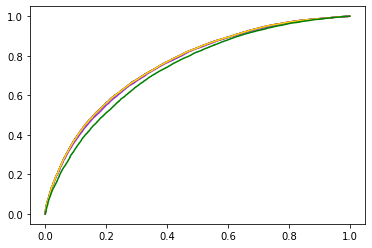

<Figure size 1440x576 with 0 Axes>

In [36]:
# Building and printing ROC curves for all final models
classes = ['First', 'Two or More']

# Logistic Regression
logreg_probs = logreg_model.predict_proba(x_validation)
logreg_probs = logreg_probs[:, 1]

# Ridge Regression, C=0.2
ridge2_probs = ridge_model2.predict_proba(x_validation)
ridge2_probs = ridge2_probs[:, 1]

# Ridge Regression, C=0.001    
ridge001_probs = ridge_model001.predict_proba(x_validation)
ridge001_probs = ridge001_probs[:, 1]

# Lasso Regression, C=0.2
lasso2_probs = lasso_model2.predict_proba(x_validation)
lasso2_probs = lasso2_probs[:, 1]

# Lasso Regression, C=0.001 
lasso001_probs = lasso_model001.predict_proba(x_validation)
lasso001_probs = lasso001_probs[:, 1]

fpr, tpr, thresh = metrics.roc_curve(y_validation, logreg_probs)
auc = metrics.roc_auc_score(y_validation, logreg_probs)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(round(auc, 2)), color = 'red')

fpr, tpr, thresh = metrics.roc_curve(y_validation, ridge2_probs)
auc = metrics.roc_auc_score(y_validation, ridge2_probs)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Ridge Regression, C=0.2, auc="+str(round(auc, 2)), color = 'blue')

fpr, tpr, thresh = metrics.roc_curve(y_validation, ridge001_probs)
auc = metrics.roc_auc_score(y_validation, ridge001_probs)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Ridge Regression, C=0.001, auc="+str(round(auc, 2)), color = 'darkorchid')

fpr, tpr, thresh = metrics.roc_curve(y_validation, lasso2_probs)
auc = metrics.roc_auc_score(y_validation, lasso2_probs)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Lasso Regression, C=0.2, auc="+str(round(auc, 2)), color = 'gold')

fpr, tpr, thresh = metrics.roc_curve(y_validation, lasso001_probs)
auc = metrics.roc_auc_score(y_validation, lasso001_probs)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="Lasso Regression, C=0.001, auc="+str(round(auc, 2)), color = 'green')

plt.figure(figsize=(20,8))